## PCA and Text Analysis

This assignment involves processing real e-mails, some of which are scams. Some of these scam e-mails have some offensive content. I don't think anything is worse than R-rated, but I just want to warn you that if you start reading the e-mail text, you might read something offensive. If that's a problem, feel free to e-mail me and we can talk about it more or you can skip the assignment.  

In [3]:
import numpy as np
import pandas as pd
import pickle
from collections import Counter
from multiprocessing.pool import Pool
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import seaborn as sns
import matplotlib.pyplot as plt

### Q1.

Open the `Phishing_Email.parquet` data. It is available at `https://data434.s3.us-east-2.amazonaws.com/Phishing_Email.parquet`, and you can download it directly using Pandas by providing that URL: `df = pd.read_parquet('https://data434.s3.us-east-2.amazonaws.com/Phishing_Email.parquet')`.

We just want to look at the first step of cleaning text data, so you can get an idea of how it works. The `Email Text` variable contains the actual text of the email and the `Email Type` takes the value `Phishing Email` or `Safe Email`. We want to predict which emails are phishing emails from their contents.

Use the `str.split()` method to break the `Phishing Email` values into **tokens**: The individual words or symbols that create text data like emails. Natural Language Processing is primarily about analyzing the frequency and co-occurrence of tokens. Print the results of your split and examine it.

In words, how would you clean the tokens and use them to predict whether the email is a phishing scam or not? A short summary of the kinds of tasks you would do and how you would run a predictive algorithm is fine.

In [4]:
# load in dataset
df = pd.read_parquet('https://data434.s3.us-east-2.amazonaws.com/Phishing_Email.parquet')
tokens = df['Email Text'].str.split() # split text into individual words/symbols
tokens.head()

,Email Text
0,"[re, :, 6, ., 1100, ,, disc, :, uniformitarian..."
1,"[the, other, side, of, *, galicismos, *, *, ga..."
2,"[re, :, equistar, deal, tickets, are, you, sti..."
3,"[Hello, I, am, your, hot, lil, horny, toy., I,..."
4,"[software, at, incredibly, low, prices, (, 86,..."


**I would clean the data by removing commonly used words that will most likely be used in both types of emails (e.g., the, and, or, etc.) and will not be predictive. I would also remove things like punctuation marks for the same purpose. To predict email type from email text, I would one-hot-encode the tokens into covariates and use them for my analysis.**

### Q2.

I aggregated all the emails into a single vector, and removed the punctuation and very common words (e.g. "the"). Run the below code chunk to open it, and use the Counter class to look at the most common words:

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
path = '/content/drive/MyDrive/SEM 7/DS 3001/lab datasets/lab 05/all_tokens.pickle'

with open(path, 'rb') as file:
    all_tokens = pickle.load(file)

from collections import Counter
token_count = Counter(all_tokens)
token_freq = token_count.most_common()

# display most common tokens:
tdf = pd.DataFrame(token_freq, columns=['token', 'count'])
print(tdf)

            token  count
0             new   1365
1            date   1202
2             get   1052
3          please   1022
4           enron    927
...           ...    ...
48686   truck[1].      1
48687       feet,      1
48688  housewifes      1
48689        dorn      1
48690   clippings      1

[48691 rows x 2 columns]


In [7]:
tdf.describe() # 48691

,count
count,48691.000000
mean,5.687889
std,27.717476
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,1365.000000


Plot a histogram of the occurrences of tokens. What do you notice about the frequency of occurrence of different tokens? How does it look?

<Axes: xlabel='count', ylabel='Count'>

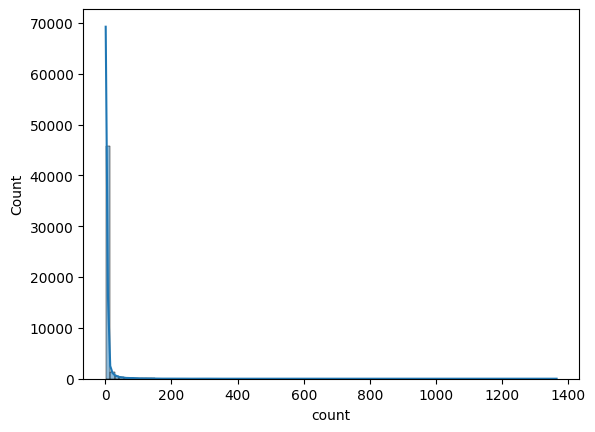

In [8]:
# histogram-
sns.histplot(tdf['count'], bins=100, kde=True)

**This histogram shows that the data is heavily skewed towards the right, meaning most of the words are used very minimally. In fact, half of the tokens in this data are only used one time. However, some words are used up to almost 1400 times- 'new' is the most frequently used word with 1365 counts! Since most of the words are not used more than once, this gives us a smaller range of tokens that can actually be predictive of email type.**

In [9]:
# load dataset
path2 = '/content/drive/MyDrive/SEM 7/DS 3001/lab datasets/lab 05/Phishing_clean.parquet'
df = pd.read_parquet(path2)
df.head() # displays one-hot-encoded features/covariates

,Email Type,new,date,get,please,enron,like,2002,would,one,...,ï¿½ï¿½,safety,yap,ypil,maintain,procedures,tip,elizabeth,leadership,italian
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Q3.

Load `Phishing_clean.parquet`. This is the text from the e-mails broken into the most common 2,711 tokens and one-hot-encoded as features/covariates. So each row is an e-mail, the `Email Type` takes the value 1 if it's a scam and 0 otherwise, and every other column is a word or symbol that occurs in at least 15 e-mails.

1. Perform an 80/20 train-test split of the data.
2. Run a regression of $y$ on the one-hot-encoded emails. What is the $R^2$ on the test set? On the training set?
3. What words have the largest coefficients in absolute value and most strongly influence predictions?

In [10]:
# 80/20 train-test split
y = df['Email Type']
X = df.drop('Email Type',axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=130)

In [11]:
# regression of y on one-hot-encoded emails
lm_0 = LinearRegression(fit_intercept=False).fit(X_train,y_train)
y_hat_test_0 = lm_0.predict(X_test)
y_hat_train_0 = lm_0.predict(X_train)
print('train: ', r2_score(y_hat_train_0,y_train) ) # R^2 (training set): 0.620
print('test: ', r2_score(y_hat_test_0,y_test) )    # R^2 (test set): -0.000

train:  0.6204455515891414
test:  -0.0001735273208884891


In [12]:
rdf = pd.DataFrame({'variable':lm_0.feature_names_in_ , 'value':lm_0.coef_})
rdf['abs'] = np.abs(rdf['value'])
rdf.sort_values('abs',ascending=False)

,variable,value,abs
40,2000,-1.553618e+13,1.553618e+13
318,100,9.457111e+12,9.457111e+12
915,300,-8.378319e+12,8.378319e+12
1014,8859,-7.646700e+12,7.646700e+12
237,1999,-7.491858e+12,7.491858e+12
...,...,...,...
1404,vlagra,2.212524e-04,2.212524e-04
1413,germanic,-1.373291e-04,1.373291e-04
1974,offered,-9.632111e-05,9.632111e-05
2034,description,-7.462502e-05,7.462502e-05


**The words with the largest coefficients/are the strongest predictors are actually just numbers. Since the training set performs well but not the test set, this model is likely too complicated and is overfitting.**

### Q4.

Take the matrix of one-hot-encoded tokens (the data, less the outcome variable, `Email Type`) and perform a principal components analysis decomposition with two components. Plot the first two principal components in a scatter plot, and hue the points by whether they are a phishing scam or not. Do you notice any patterns?

<Axes: >

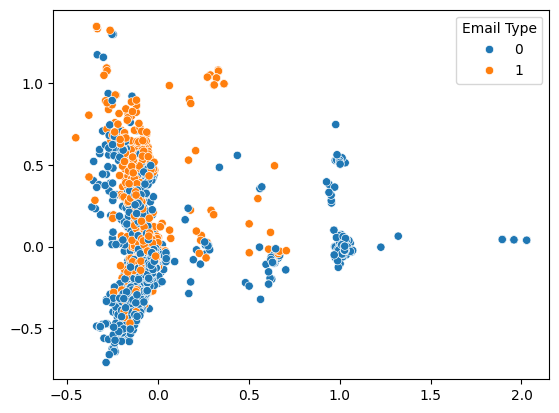

In [14]:
# PCA
PCA_decomp = PCA(n_components=2).fit(X_train)
Z_train = PCA_decomp.transform(X_train)
Z_test = PCA_decomp.transform(X_test)

# plot PCA
sns.scatterplot(x=Z_test[:,0],y=Z_test[:,1],hue=y_test)

**Emails that were a phishing scam (orange) tended to group higher on the y-axis, and lower on the x-axis. The other email type is a bit more spread out, but similarly largely grouped higher on the y-axis and lower on the x-axis. The y-axis represents the second component, and the x-axis represents our first component.**

### Q5.

Run a linear regression of $y$ on the first 2,610 principal components of $X$. What is the $R^2$ on the training and test sets? (I used cross validation to determine that 2,610 was approximately optimal, but not all 2,711 components.)

How does this performance compare to the linear regression?

In [15]:
PC = PCA(n_components=2610).fit(X_train)
Z_train = PC.transform(X_train)
Z_test = PC.transform(X_test)

# linear regression
lrm = LinearRegression().fit(Z_train,y_train)
y_hat_test = lrm.predict(Z_test)
y_hat_train = lrm.predict(Z_train)

print('Train r2: ', r2_score(y_hat_train,y_train) ) # R^2 (training set): .691
print('Test r2: ', r2_score(y_hat_test,y_test) )    # R^2 (test set): .587

Train r2:  0.6908381908640289
Test r2:  0.5866014380836957


**This model performs much better than the linear regression, with the test set approaching much closer to 1.0 in the PCA and nearly the same value as the training set. This is likely due to the PCA helping with the multicolinearity issue we were running into before with the too complex data.**

### Q6.

Explain briefly in your own words what the advantage is in using the principal components to run this high-dimensional regression, rather than the original data.

**PCA is a great way to address multicolinearity as it makes the features of the data independent of each other, leading to more accurate results. The data can also be more easily interpreted by reducing its components, which also helps with the overfitting issue.**